In [1]:
import copy
import gc
import json
import os
from pathlib import Path
import sys
import time
import traceback
from typing import List, Tuple, Dict, Union, Optional
import warnings

import torch
from anndata import AnnData
import scanpy as sc
import scvi
import numpy as np
import wandb
from scipy.sparse import issparse
import matplotlib.pyplot as plt
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchtext.vocab import Vocab
from torchtext._torchtext import (
    Vocab as VocabPybind,
)

from scgpt.tokenizer.gene_tokenizer import GeneVocab

sys.path.append("../")
import scgpt as scg
from scgpt.model import TransformerModel, AdversarialDiscriminator
from scgpt.tokenizer import tokenize_and_pad_batch, random_mask_value
from scgpt.loss import (
    masked_mse_loss,
    masked_relative_error,
    criterion_neg_log_bernoulli,
    masked_ce_loss
)
from scgpt.preprocess import Preprocessor
from scgpt import SubsetsBatchSampler
from scgpt.utils import set_seed, category_str2int, eval_scib_metrics


# from functions_group import DistanceLoss

sc.set_figure_params(figsize=(4, 4))
os.environ["KMP_WARNINGS"] = "off"
# os.environ["WANDB_MODE"] = "offline"

hyperparameter_defaults = dict(
    seed=42,
    dataset_name="PBMC_10K",
    do_train=True,
    load_model="save/scGPT_bc",
    mask_ratio=0.4,
    epochs=10,
    n_bins=51,
    GEPC=True,  # Masked value prediction for cell embedding
    ecs_thres=0.8,  # Elastic cell similarity objective, 0.0 to 1.0, 0.0 to disable
    dab_weight=1.0,
    lr=1e-4,
    batch_size=32,
    layer_size=128,
    nlayers=4,
    nhead=4,
    # if load model, batch_size, layer_size, nlayers, nhead will be ignored
    dropout=0.2,
    schedule_ratio=0.9,  # ratio of epochs for learning rate schedule
    save_eval_interval=5,
    log_interval=100,
    fast_transformer=True,
    pre_norm=False,
    amp=True,  # Automatic Mixed Precision
)

run = wandb.init(
    config=hyperparameter_defaults,
    project="scGPT",
    reinit=True,
    settings=wandb.Settings(start_method="fork"),
)
config = wandb.config
print(config)

Global seed set to 0
/gpfs/gibbs/project/zhao/tl688/conda_envs/scgpt/lib/python3.8/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tianyu-18 (zhao-lab). Use `wandb login --relogin` to force relogin
/gpfs/gibbs/project/zhao/tl688/conda_envs/scgpt/lib/python3.8/site-packages/wandb/sdk/lib/ipython.py:70: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


{'seed': 42, 'dataset_name': 'PBMC_10K', 'do_train': True, 'load_model': 'save/scGPT_bc', 'mask_ratio': 0.4, 'epochs': 10, 'n_bins': 51, 'GEPC': True, 'ecs_thres': 0.8, 'dab_weight': 1.0, 'lr': 0.0001, 'batch_size': 32, 'layer_size': 128, 'nlayers': 4, 'nhead': 4, 'dropout': 0.2, 'schedule_ratio': 0.9, 'save_eval_interval': 5, 'log_interval': 100, 'fast_transformer': True, 'pre_norm': False, 'amp': True}


In [2]:
def order_selection(adata, key='batch', orders=None):
    '''Function used to determine the training sequence based on the variance across genes.
        Args:
            adata: The given dataset in AnnData form
            key: The index name of batch information in the given dataset
            orders: The batch sequence for training or none
        Output:
            orders: The batch sequence for training
    '''
    if orders == None:
        batch_list = list(set(adata.obs[key].values))
        adata_values = [np.array(adata.X[adata.obs[key] == batch]) for batch in batch_list]
        std_ = [np.sum(np.std(item, axis=0)) for item in adata_values]
        orders = np.argsort(std_)[::-1]
        return [batch_list[i] for i in orders] 
    else:
        return orders

def generate_target_dataset(adata, batch_list):
    """A simple function used to rearrange the batch index of our given dataset.
    """
    adata0 = adata[adata.obs['batch'] == batch_list[0]]
    for i in batch_list[1:]:
        adata0 = adata0.concatenate(adata[adata.obs['batch'] == i], batch_key='batch_key', index_unique=None)
    return adata0

In [3]:
set_seed(config.seed)

# %%
# settings for input and preprocessing
pad_token = "<pad>"
special_tokens = [pad_token, "<cls>", "<eoc>"]
mask_ratio = config.mask_ratio
mask_value = -1
pad_value = -2
n_input_bins = config.n_bins

n_hvg = 2000  # number of highly variable genes
max_seq_len = n_hvg + 1
per_seq_batch_sample = False
DSBN = True  # Domain-spec batchnorm
explicit_zero_prob = True  # whether explicit bernoulli for zeros

# %%
dataset_name = config.dataset_name
save_dir = Path(f"./save/dev_{dataset_name}-{time.strftime('%b%d-%H-%M')}/")
save_dir.mkdir(parents=True, exist_ok=True)
print(f"save to {save_dir}")
# save the whole script to the dir
# os.system(f"cp {__file__} {save_dir}")

logger = scg.logger
scg.utils.add_file_handler(logger, save_dir / "run.log")


# %% [markdown]
# ## Loading and preparing data
# if dataset_name == "PBMC_10K":
#     adata = scvi.data.pbmc_dataset()  # 11990 × 3346
#     ori_batch_col = "batch"
#     adata.obs["celltype"] = adata.obs["str_labels"].astype("category")
#     adata.var = adata.var.set_index("gene_symbols")
#     data_is_raw = True



adata = sc.read_loom("/gpfs/ysm/pi/zhao/tl688/datasets/MHSP_raw.loom")  # 11990 × 3346
adata.var_names = [i.upper() for i in adata.var_names]
adata = sc.AnnData(adata.X.todense(), obs = adata.obs, var = adata.var)
ori_batch_col = "batch"
adata.obs["celltype"] = adata.obs["celltype"].astype("category")
data_is_raw = True


order = order_selection(adata) 
adata = generate_target_dataset(adata, order)
# adata = adata[[True if i in ["Batch3_fluidigmc1", "Batch5_smartseq2"] else False for i in adata.obs.batch]]

# %%
# make the batch category column
adata.obs["str_batch"] = adata.obs[ori_batch_col].astype(str)
batch_id_labels = adata.obs["str_batch"].astype("category").cat.codes.values
adata.obs["batch_id"] = batch_id_labels

adata.var["gene_name"] = adata.var.index.tolist()

if config.load_model is not None:
    model_dir = Path(config.load_model)
    model_config_file = model_dir / "args.json"
    model_file = model_dir / "best_model.pt"
    vocab_file = model_dir / "vocab.json"

    vocab = GeneVocab.from_file(vocab_file)
    for s in special_tokens:
        if s not in vocab:
            vocab.append_token(s)

    adata.var["id_in_vocab"] = [
        1 if gene in vocab else -1 for gene in adata.var["gene_name"]
    ]
    gene_ids_in_vocab = np.array(adata.var["id_in_vocab"])
    logger.info(
        f"match {np.sum(gene_ids_in_vocab >= 0)}/{len(gene_ids_in_vocab)} genes "
        f"in vocabulary of size {len(vocab)}."
    )
    adata = adata[:, adata.var["id_in_vocab"] >= 0]

    # model
    with open(model_config_file, "r") as f:
        model_configs = json.load(f)
    logger.info(
        f"Resume model from {model_file}, the model args will override the "
        f"config {model_config_file}."
    )
    embsize = model_configs["embsize"]
    nhead = model_configs["nheads"]
    d_hid = model_configs["d_hid"]
    nlayers = model_configs["nlayers"]
    n_layers_cls = model_configs["n_layers_cls"]




save to save/dev_PBMC_10K-Jul01-10-18


/gpfs/gibbs/project/zhao/tl688/conda_envs/scgpt/lib/python3.8/site-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
/gpfs/gibbs/project/zhao/tl688/conda_envs/scgpt/lib/python3.8/site-packages/loompy/bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def dna_to_twobit(dna: s

scGPT - INFO - match 3068/3467 genes in vocabulary of size 36574.
scGPT - INFO - Resume model from save/scGPT_bc/best_model.pt, the model args will override the config save/scGPT_bc/args.json.


/gpfs/gibbs/project/zhao/tl688/conda_envs/scgpt/lib/python3.8/site-packages/anndata/_core/anndata.py:1755: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


In [4]:
adata.obs.batch

CellID
HSPC_007    Batch2_smartseq2
HSPC_013    Batch2_smartseq2
HSPC_019    Batch2_smartseq2
HSPC_025    Batch2_smartseq2
HSPC_031    Batch2_smartseq2
                  ...       
W39163        Batch1_marsseq
W39164        Batch1_marsseq
W39165        Batch1_marsseq
W39167        Batch1_marsseq
W39168        Batch1_marsseq
Name: batch, Length: 4184, dtype: object

In [5]:
# %%
# set up the preprocessor, use the args to config the workflow
preprocessor = Preprocessor(
    use_key="X",  # the key in adata.layers to use as raw data
    filter_gene_by_counts=3,  # step 1
    filter_cell_by_counts=False,  # step 2
    normalize_total=1e4,  # 3. whether to normalize the raw data and to what sum
    result_normed_key="X_normed",  # the key in adata.layers to store the normalized data
    log1p=data_is_raw,  # 4. whether to log1p the normalized data
    result_log1p_key="X_log1p",
    subset_hvg=n_hvg,  # 5. whether to subset the raw data to highly variable genes
    hvg_flavor="seurat_v3" if data_is_raw else "cell_ranger",
    binning=config.n_bins,  # 6. whether to bin the raw data and to what number of bins
    result_binned_key="X_binned",  # the key in adata.layers to store the binned data
)
preprocessor(adata, batch_key="batch" if dataset_name != "heart_cell" else None)

# %%
if per_seq_batch_sample:
    # sort the adata by batch_id in advance
    adata_sorted = adata[adata.obs["batch_id"].argsort()].copy()

# %% [markdown]
# ## Tokenize input

# %%
input_layer_key = "X_binned"
all_counts = (
    adata.layers[input_layer_key].A
    if issparse(adata.layers[input_layer_key])
    else adata.layers[input_layer_key]
)
genes = adata.var["gene_name"].tolist()

celltypes_labels = adata.obs["celltype"].tolist()  # make sure count from 0
num_types = len(set(celltypes_labels))
celltypes_labels = np.array(celltypes_labels)

batch_ids = adata.obs["batch_id"].tolist()
num_batch_types = len(set(batch_ids))
batch_ids = np.array(batch_ids)

(
    train_data,
    valid_data,
    train_celltype_labels,
    valid_celltype_labels,
    train_batch_labels,
    valid_batch_labels,
) = train_test_split(
    all_counts, celltypes_labels, batch_ids, test_size=0.001, shuffle=True
)

# %%
if config.load_model is None:
    vocab = Vocab(
        VocabPybind(genes + special_tokens, None)
    )  # bidirectional lookup [gene <-> int]
vocab.set_default_index(vocab["<pad>"])
gene_ids = np.array(vocab(genes), dtype=int)

# %%
tokenized_train = tokenize_and_pad_batch(
    train_data,
    gene_ids,
    max_len=max_seq_len,
    vocab=vocab,
    pad_token=pad_token,
    pad_value=pad_value,
    append_cls=True,  # append <cls> token at the beginning
    include_zero_gene=True,
)
tokenized_valid = tokenize_and_pad_batch(
    valid_data,
    gene_ids,
    max_len=max_seq_len,
    vocab=vocab,
    pad_token=pad_token,
    pad_value=pad_value,
    append_cls=True,
    include_zero_gene=True,
)
logger.info(
    f"train set number of samples: {tokenized_train['genes'].shape[0]}, "
    f"\n\t feature length: {tokenized_train['genes'].shape[1]}"
)
logger.info(
    f"valid set number of samples: {tokenized_valid['genes'].shape[0]}, "
    f"\n\t feature length: {tokenized_valid['genes'].shape[1]}"
)


# %%
def prepare_data(sort_seq_batch=False) -> Tuple[Dict[str, torch.Tensor]]:
    masked_values_train = random_mask_value(
        tokenized_train["values"],
        mask_ratio=mask_ratio,
        mask_value=mask_value,
        pad_value=pad_value,
    )
    masked_values_valid = random_mask_value(
        tokenized_valid["values"],
        mask_ratio=mask_ratio,
        mask_value=mask_value,
        pad_value=pad_value,
    )
    print(
        f"random masking at epoch {epoch:3d}, ratio of masked values in train: ",
        f"{(masked_values_train == mask_value).sum() / (masked_values_train - pad_value).count_nonzero():.4f}",
    )

    input_gene_ids_train, input_gene_ids_valid = (
        tokenized_train["genes"],
        tokenized_valid["genes"],
    )
    input_values_train, input_values_valid = masked_values_train, masked_values_valid
    target_values_train, target_values_valid = (
        tokenized_train["values"],
        tokenized_valid["values"],
    )

    tensor_batch_labels_train = torch.from_numpy(train_batch_labels).long()
    tensor_batch_labels_valid = torch.from_numpy(valid_batch_labels).long()

    if sort_seq_batch:
        train_sort_ids = np.argsort(train_batch_labels)
        input_gene_ids_train = input_gene_ids_train[train_sort_ids]
        input_values_train = input_values_train[train_sort_ids]
        target_values_train = target_values_train[train_sort_ids]
        tensor_batch_labels_train = tensor_batch_labels_train[train_sort_ids]

        valid_sort_ids = np.argsort(valid_batch_labels)
        input_gene_ids_valid = input_gene_ids_valid[valid_sort_ids]
        input_values_valid = input_values_valid[valid_sort_ids]
        target_values_valid = target_values_valid[valid_sort_ids]
        tensor_batch_labels_valid = tensor_batch_labels_valid[valid_sort_ids]

    train_data_pt = {
        "gene_ids": input_gene_ids_train,
        "values": input_values_train,
        "target_values": target_values_train,
        "batch_labels": tensor_batch_labels_train,
    }
    valid_data_pt = {
        "gene_ids": input_gene_ids_valid,
        "values": input_values_valid,
        "target_values": target_values_valid,
        "batch_labels": tensor_batch_labels_valid,
    }

    return train_data_pt, valid_data_pt


# dataset
class SeqDataset(Dataset):
    def __init__(self, data: Dict[str, torch.Tensor]):
        self.data = data

    def __len__(self):
        return self.data["gene_ids"].shape[0]

    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.data.items()}


# data_loader
def prepare_dataloader(
    data_pt: Dict[str, torch.Tensor],
    batch_size: int,
    shuffle: bool = False,
    intra_domain_shuffle: bool = False,
    drop_last: bool = False,
    num_workers: int = 0,
) -> DataLoader:
    dataset = SeqDataset(data_pt)

    if per_seq_batch_sample:
        # find the indices of samples in each seq batch
        subsets = []
        batch_labels_array = data_pt["batch_labels"].numpy()
        for batch_label in np.unique(batch_labels_array):
            batch_indices = np.where(batch_labels_array == batch_label)[0].tolist()
            subsets.append(batch_indices)
        data_loader = DataLoader(
            dataset=dataset,
            batch_sampler=SubsetsBatchSampler(
                subsets,
                batch_size,
                intra_subset_shuffle=intra_domain_shuffle,
                inter_subset_shuffle=shuffle,
                drop_last=drop_last,
            ),
            num_workers=num_workers,
            pin_memory=True,
        )
        return data_loader

    data_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,
    )
    return data_loader

scGPT - INFO - Filtering genes by counts ...
scGPT - INFO - Filtering cells by counts ...
scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Log1p transforming ...


/gpfs/gibbs/project/zhao/tl688/conda_envs/scgpt/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:249: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_counts'] = number


scGPT - INFO - Subsetting highly variable genes ...
scGPT - INFO - Binning data ...
scGPT - INFO - train set number of samples: 4179, 
	 feature length: 2001
scGPT - INFO - valid set number of samples: 5, 
	 feature length: 2001


In [6]:
# %% [markdown]
# # Create and finetune scGPT

# %%
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ntokens = len(vocab)  # size of vocabulary
model = TransformerModel(
    ntokens,
    embsize,
    nhead,
    d_hid,
    nlayers,
    vocab=vocab,
    dropout=config.dropout,
    pad_token=pad_token,
    pad_value=pad_value,
    do_mvc=config.GEPC,
    do_dab=True,
    use_batch_labels=True,
    num_batch_labels=num_batch_types,
    domain_spec_batchnorm=DSBN,
    n_input_bins=n_input_bins,
    ecs_threshold=config.ecs_thres,
    explicit_zero_prob=explicit_zero_prob,
    use_fast_transformer=True,
    pre_norm=config.pre_norm,
)
if config.load_model is not None:
    try:
        model.load_state_dict(torch.load(model_file))
        logger.info(f"Loading all model params from {model_file}")
    except:
        # only load params that are in the model and match the size
        model_dict = model.state_dict()
        pretrained_dict = torch.load(model_file)
        pretrained_dict = {
            k: v
            for k, v in pretrained_dict.items()
            if k in model_dict and v.shape == model_dict[k].shape
        }
        for k, v in pretrained_dict.items():
            logger.info(f"Loading params {k} with shape {v.shape}")
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict)

model.to(device)
# wandb.watch(model)


# criterion = masked_mse_loss
criterion = masked_ce_loss


criterion_dab = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=config.lr, eps=1e-4 if config.amp else 1e-8
)

# optimizer = SophiaG(model.parameters(), lr=config.lr, betas=(0.965, 0.99), rho = 0.01, weight_decay=1e-1)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=config.schedule_ratio)

scaler = torch.cuda.amp.GradScaler(enabled=config.amp)

Use domain specific batchnorm with affine=False
scGPT - INFO - Loading params encoder.embedding.weight with shape torch.Size([36574, 512])
scGPT - INFO - Loading params encoder.enc_norm.weight with shape torch.Size([512])
scGPT - INFO - Loading params encoder.enc_norm.bias with shape torch.Size([512])
scGPT - INFO - Loading params value_encoder.linear1.weight with shape torch.Size([512, 1])
scGPT - INFO - Loading params value_encoder.linear1.bias with shape torch.Size([512])
scGPT - INFO - Loading params value_encoder.linear2.weight with shape torch.Size([512, 512])
scGPT - INFO - Loading params value_encoder.linear2.bias with shape torch.Size([512])
scGPT - INFO - Loading params value_encoder.norm.weight with shape torch.Size([512])
scGPT - INFO - Loading params value_encoder.norm.bias with shape torch.Size([512])
scGPT - INFO - Loading params transformer_encoder.layers.0.self_attn.Wqkv.weight with shape torch.Size([1536, 512])
scGPT - INFO - Loading params transformer_encoder.layers.

scGPT - INFO - Loading params transformer_encoder.layers.5.norm2.weight with shape torch.Size([512])
scGPT - INFO - Loading params transformer_encoder.layers.5.norm2.bias with shape torch.Size([512])
scGPT - INFO - Loading params transformer_encoder.layers.6.self_attn.Wqkv.weight with shape torch.Size([1536, 512])
scGPT - INFO - Loading params transformer_encoder.layers.6.self_attn.Wqkv.bias with shape torch.Size([1536])
scGPT - INFO - Loading params transformer_encoder.layers.6.self_attn.out_proj.weight with shape torch.Size([512, 512])
scGPT - INFO - Loading params transformer_encoder.layers.6.self_attn.out_proj.bias with shape torch.Size([512])
scGPT - INFO - Loading params transformer_encoder.layers.6.linear1.weight with shape torch.Size([512, 512])
scGPT - INFO - Loading params transformer_encoder.layers.6.linear1.bias with shape torch.Size([512])
scGPT - INFO - Loading params transformer_encoder.layers.6.linear2.weight with shape torch.Size([512, 512])
scGPT - INFO - Loading para

scGPT - INFO - Loading params mvc_decoder.gene2query.weight with shape torch.Size([512, 512])
scGPT - INFO - Loading params mvc_decoder.gene2query.bias with shape torch.Size([512])


In [7]:
def train(model: nn.Module, loader: DataLoader) -> None:
    """
    Train the model for one epoch.
    """
    model.train()
    total_loss, total_mse, total_gepc = 0.0, 0.0, 0.0
    total_error = 0.0
    log_interval = config.log_interval
    start_time = time.time()

    num_batches = len(loader)
    for batch, batch_data in enumerate(loader):
        input_gene_ids = batch_data["gene_ids"].to(device)
        input_values = batch_data["values"].to(device)
        target_values = batch_data["target_values"].to(device)
        batch_labels = batch_data["batch_labels"].to(device)
        
        src_key_padding_mask = input_gene_ids.eq(vocab[pad_token])
        with torch.cuda.amp.autocast(enabled=config.amp):
            output_dict = model(
                input_gene_ids,
                input_values,
                src_key_padding_mask=src_key_padding_mask,
                batch_labels=batch_labels if DSBN else None,
                MVC=config.GEPC,
                ECS=config.ecs_thres > 0,
            )
            

            masked_positions = input_values.eq(mask_value)  # the postions to predict
            
#             loss = loss_mse = torch.FloatTensor([0.0]).cuda()
            
            loss = loss_mse = criterion(
                output_dict["mlm_output"], target_values, masked_positions
            )
            metrics_to_log = {"train/mse": loss_mse.item()}
            
            if explicit_zero_prob:
                loss_zero_log_prob = criterion_neg_log_bernoulli(
                    output_dict["mlm_zero_probs"], target_values, masked_positions
                )
                loss = loss + loss_zero_log_prob
                metrics_to_log.update({"train/nzlp": loss_zero_log_prob.item()})
                
            if config.GEPC:
                loss_gepc = criterion(
                    output_dict["mvc_output"], target_values, masked_positions
                )
                loss = loss + loss_gepc
                metrics_to_log.update({"train/mvc": loss_gepc.item()})

            if config.GEPC and explicit_zero_prob:
                loss_gepc_zero_log_prob = criterion_neg_log_bernoulli(
                    output_dict["mvc_zero_probs"], target_values, masked_positions
                )
                loss = loss + loss_gepc_zero_log_prob
                metrics_to_log.update(
                    {"train/mvc_nzlp": loss_gepc_zero_log_prob.item()}
                )

#             if config.ecs_thres > 0:
#                 loss_ecs = 10 * output_dict["loss_ecs"]
#                 loss = loss + loss_ecs
#                 metrics_to_log.update({"train/ecs": loss_ecs.item()})

#             loss_gepc = torch.FloatTensor([0.0])
            
            loss_dab = criterion_dab(output_dict["dab_output"], batch_labels)
            loss = loss + config.dab_weight * loss_dab
            metrics_to_log.update({"train/dab": loss_dab.item()})

        model.zero_grad()
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        with warnings.catch_warnings(record=True) as w:
            warnings.filterwarnings("always")
            torch.nn.utils.clip_grad_norm_(
                model.parameters(),
                1.0,
                error_if_nonfinite=False if scaler.is_enabled() else True,
            )
            if len(w) > 0:
                logger.warning(
                    f"Found infinite gradient. This may be caused by the gradient "
                    f"scaler. The current scale is {scaler.get_scale()}. This warning "
                    "can be ignored if no longer occurs after autoscaling of the scaler."
                )
        scaler.step(optimizer)
        scaler.update()

        wandb.log(metrics_to_log)

        with torch.no_grad():
            mre = masked_relative_error(
                output_dict["mlm_output"], target_values, masked_positions
            )

        total_loss += loss.item()
        total_mse += loss_mse.item()
        total_gepc += loss_gepc.item() if config.GEPC else 0.0
        total_error += mre.item()
        if batch % log_interval == 0 and batch > 0:
            lr = scheduler.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            cur_mse = total_mse / log_interval
            cur_gepc = total_gepc / log_interval if config.GEPC else 0.0
            cur_error = total_error / log_interval
            # ppl = math.exp(cur_loss)
            logger.info(
                f"| epoch {epoch:3d} | {batch:3d}/{num_batches:3d} batches | "
                f"lr {lr:05.4f} | ms/batch {ms_per_batch:5.2f} | "
                f"loss {cur_loss:5.2f} | mse {cur_mse:5.2f} | mre {cur_error:5.2f} |"
                + (f"gepc {cur_gepc:5.2f} |" if config.GEPC else "")
            )
            total_loss = 0
            total_mse = 0
            total_gepc = 0
            total_error = 0
            start_time = time.time()


def define_wandb_metrcis():
    wandb.define_metric("valid/mse", summary="min", step_metric="epoch")
    wandb.define_metric("valid/mre", summary="min", step_metric="epoch")
    wandb.define_metric("valid/dab", summary="min", step_metric="epoch")
    wandb.define_metric("valid/sum_mse_dab", summary="min", step_metric="epoch")
    wandb.define_metric("test/avg_bio", summary="max")


def evaluate(model: nn.Module, loader: DataLoader) -> float:
    """
    Evaluate the model on the evaluation data.
    """
    model.eval()
    total_loss = 0.0
    total_error = 0.0
    total_dab = 0.0
    total_num = 0
    with torch.no_grad():
        for batch_data in loader:
            input_gene_ids = batch_data["gene_ids"].to(device)
            input_values = batch_data["values"].to(device)
            target_values = batch_data["target_values"].to(device)
            batch_labels = batch_data["batch_labels"].to(device)

            src_key_padding_mask = input_gene_ids.eq(vocab[pad_token])
            with torch.cuda.amp.autocast(enabled=config.amp):
                output_dict = model(
                    input_gene_ids,
                    input_values,
                    src_key_padding_mask=src_key_padding_mask,
                    batch_labels=batch_labels if DSBN else None,
                )
                output_values = output_dict["mlm_output"]

                masked_positions = input_values.eq(mask_value)
                loss = criterion(output_values, target_values, masked_positions)
                loss_dab = criterion_dab(output_dict["dab_output"], batch_labels)

            total_loss += loss.item() * len(input_gene_ids)
            total_error += masked_relative_error(
                output_values, target_values, masked_positions
            ).item() * len(input_gene_ids)
            total_dab += loss_dab.item() * len(input_gene_ids)
            total_num += len(input_gene_ids)

    wandb.log(
        {
            "valid/mse": total_loss / total_num,
            "valid/mre": total_error / total_num,
            "valid/dab": total_dab / total_num,
            "valid/sum_mse_dab": (total_loss + config.dab_weight * total_dab)
            / total_num,
            "epoch": epoch,
        },
    )

    return total_loss / total_num, total_error / total_num


def eval_testdata(
    model: nn.Module,
    adata_t: AnnData,
    include_types: List[str] = ["cls"],
) -> Optional[Dict]:
    """evaluate the model on test dataset of adata_t"""
    model.eval()

    # copy adata_t to avoid reuse previously computed results stored in adata_t
    adata_t = adata_t.copy()

    all_counts = (
        adata_t.layers[input_layer_key].A
        if issparse(adata_t.layers[input_layer_key])
        else adata_t.layers[input_layer_key]
    )

    celltypes_labels = adata_t.obs["celltype"].tolist()
    celltypes_labels = np.array(celltypes_labels)

    batch_ids = adata_t.obs["batch_id"].tolist()
    batch_ids = np.array(batch_ids)

    # Evaluate cls cell embeddings
    if "cls" in include_types:
        logger.info("Evaluating cls cell embeddings")
        tokenized_all = tokenize_and_pad_batch(
            all_counts,
            gene_ids,
            max_len=max_seq_len,
            vocab=vocab,
            pad_token=pad_token,
            pad_value=pad_value,
            append_cls=True,  # append <cls> token at the beginning
            include_zero_gene=True,
        )
        all_gene_ids, all_values = tokenized_all["genes"], tokenized_all["values"]
        src_key_padding_mask = all_gene_ids.eq(vocab[pad_token])
        with torch.no_grad(), torch.cuda.amp.autocast(enabled=config.amp):
            cell_embeddings = model.encode_batch(
                all_gene_ids,
                all_values.float(),
                src_key_padding_mask=src_key_padding_mask,
                batch_size=config.batch_size,
                batch_labels=torch.from_numpy(batch_ids).long() if DSBN else None,
                time_step=0,
                return_np=True,
            )
        cell_embeddings = cell_embeddings / np.linalg.norm(
            cell_embeddings, axis=1, keepdims=True
        )

        adata_t.obsm["X_scGPT"] = cell_embeddings

        results = {}
        try:
            results = eval_scib_metrics(adata_t)
        except Exception as e:
            traceback.print_exc()
            logger.error(e)

        sc.pp.neighbors(adata_t, use_rep="X_scGPT")
        sc.tl.umap(adata_t, min_dist=0.3)
        fig = sc.pl.umap(
            adata_t,
            color=["str_batch"],
            title=[f"batch, avg_bio = {results.get('avg_bio', 0.0):.4f}"],
            frameon=False,
            return_fig=True,
            show=False,
        )

        results["batch_umap"] = fig

        sc.pp.neighbors(adata_t, use_rep="X_scGPT")
        sc.tl.umap(adata_t, min_dist=0.3)
        fig = sc.pl.umap(
            adata_t,
            color=["celltype"],
            title=[
                f"celltype, avg_bio = {results.get('avg_bio', 0.0):.4f}",
            ],
            frameon=False,
            return_fig=True,
            show=False,
        )

        results["celltype_umap"] = fig

    if len(include_types) == 1:
        return results
    
    
def return_testdata(
    model: nn.Module,
    adata_t: AnnData,
    include_types: List[str] = ["cls"],
) -> Optional[Dict]:
    """evaluate the model on test dataset of adata_t"""
    model.eval()

    # copy adata_t to avoid reuse previously computed results stored in adata_t
    adata_t = adata_t.copy()

    all_counts = (
        adata_t.layers[input_layer_key].A
        if issparse(adata_t.layers[input_layer_key])
        else adata_t.layers[input_layer_key]
    )

    celltypes_labels = adata_t.obs["celltype"].tolist()
    celltypes_labels = np.array(celltypes_labels)

    batch_ids = adata_t.obs["batch_id"].tolist()
    batch_ids = np.array(batch_ids)

    # Evaluate cls cell embeddings
    if "cls" in include_types:
        logger.info("Evaluating cls cell embeddings")
        tokenized_all = tokenize_and_pad_batch(
            all_counts,
            gene_ids,
            max_len=max_seq_len,
            vocab=vocab,
            pad_token=pad_token,
            pad_value=pad_value,
            append_cls=True,  # append <cls> token at the beginning
            include_zero_gene=True,
        )
        all_gene_ids, all_values = tokenized_all["genes"], tokenized_all["values"]
        src_key_padding_mask = all_gene_ids.eq(vocab[pad_token])
        with torch.no_grad(), torch.cuda.amp.autocast(enabled=config.amp):
            cell_embeddings = model.encode_batch(
                all_gene_ids,
                all_values.float(),
                src_key_padding_mask=src_key_padding_mask,
                batch_size=config.batch_size,
                batch_labels=torch.from_numpy(batch_ids).long() if DSBN else None,
                time_step=0,
                return_np=True,
            )
        cell_embeddings = cell_embeddings / np.linalg.norm(
            cell_embeddings, axis=1, keepdims=True
        )
        
    return cell_embeddings

def return_allemb(
    model: nn.Module,
    adata_t: AnnData,
    include_types: List[str] = ["cls"],
) -> Optional[Dict]:
    """evaluate the model on test dataset of adata_t"""
    model.eval()

    # copy adata_t to avoid reuse previously computed results stored in adata_t
    adata_t = adata_t.copy()
    
#     adata_t = adata_t[0:100,:]

    all_counts = adata_t.layers[input_layer_key].A if issparse(adata_t.layers[input_layer_key]) else adata_t.layers[input_layer_key]
    

    celltypes_labels = adata_t.obs["celltype"].tolist()
    celltypes_labels = np.array(celltypes_labels)

    batch_ids = adata_t.obs["batch_id"].tolist()
    batch_ids = np.array(batch_ids)

    # Evaluate cls cell embeddings
    if "cls" in include_types:
        logger.info("Evaluating cls cell embeddings")
        tokenized_all = tokenize_and_pad_batch(
            all_counts,
            gene_ids,
            max_len=max_seq_len,
            vocab=vocab,
            pad_token=pad_token,
            pad_value=pad_value,
            append_cls=True,  # append <cls> token at the beginning
            include_zero_gene=True,
        )
        all_gene_ids, all_values = tokenized_all["genes"], tokenized_all["values"]
        src_key_padding_mask = all_gene_ids.eq(vocab[pad_token])
        
        all_gene_ids = all_gene_ids.to(device),
        all_values = all_values.to(device),
        src_key_padding_mask=src_key_padding_mask.to(device),
        batch_labels=torch.from_numpy(batch_ids).to(device) if DSBN else None,
        
        with torch.no_grad(), torch.cuda.amp.autocast(enabled=config.amp):
            cell_embeddings = model(
                    all_gene_ids,
                    all_values,
                    src_key_padding_mask=src_key_padding_mask,
                    batch_labels=batch_labels,
                    MVC=config.GEPC,
                    ECS=config.ecs_thres > 0,
                )
        
    return cell_embeddings

In [11]:
### %%time
best_val_loss = float("inf")
best_avg_bio = 0.0
best_model = None
define_wandb_metrcis()

for epoch in range(1, config.epochs + 1):
    epoch_start_time = time.time()
    train_data_pt, valid_data_pt = prepare_data(sort_seq_batch=per_seq_batch_sample)
    train_loader = prepare_dataloader(
        train_data_pt,
        batch_size=config.batch_size,
        shuffle=True,
        intra_domain_shuffle=True,
        drop_last=False,
    )
    valid_loader = prepare_dataloader(
        valid_data_pt,
        batch_size=config.batch_size,
        shuffle=False,
        intra_domain_shuffle=False,
        drop_last=False,
    )

    if config.do_train:
        train(
            model,
            loader=train_loader,
        )
    val_loss, val_mre = evaluate(
        model,
        loader=valid_loader,
    )
    elapsed = time.time() - epoch_start_time
    logger.info("-" * 89)
    logger.info(
        f"| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | "
        f"valid loss/mse {val_loss:5.4f} | mre {val_mre:5.4f}"
    )
    logger.info("-" * 89)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(model)
        best_model_epoch = epoch
        logger.info(f"Best model with score {best_val_loss:5.4f}")

    if epoch % config.save_eval_interval == 0 or epoch == config.epochs:
        continue
#         logger.info(f"Saving model to {save_dir}")
#         torch.save(best_model.state_dict(), save_dir / f"model_e{best_model_epoch}.pt")

#         # eval on testdata
#         results = eval_testdata(
#             best_model,
#             adata_t=adata_sorted if per_seq_batch_sample else adata,
#             include_types=["cls"],
#         )
#         results["batch_umap"].savefig(
#             save_dir / f"embeddings_batch_umap[cls]_e{best_model_epoch}.png", dpi=300
#         )

#         results["celltype_umap"].savefig(
#             save_dir / f"embeddings_celltype_umap[cls]_e{best_model_epoch}.png", dpi=300
#         )
#         metrics_to_log = {"test/" + k: v for k, v in results.items()}
#         metrics_to_log["test/batch_umap"] = wandb.Image(
#             str(save_dir / f"embeddings_batch_umap[cls]_e{best_model_epoch}.png"),
#             caption=f"celltype avg_bio epoch {best_model_epoch}",
#         )

#         metrics_to_log["test/celltype_umap"] = wandb.Image(
#             str(save_dir / f"embeddings_celltype_umap[cls]_e{best_model_epoch}.png"),
#             caption=f"celltype avg_bio epoch {best_model_epoch}",
#         )
#         # metrics_to_log["test/best_model_epoch"] = best_model_epoch
#         wandb.log(metrics_to_log)
#         wandb.log({"avg_bio": results.get("avg_bio", 0.0)})

    scheduler.step()


# %%
# save the best model
torch.save(best_model.state_dict(), save_dir / "best_model.pt")

# %% [markdown]
# ## Gene embeddings

# %%
artifact = wandb.Artifact(f"best_model", type="model")
glob_str = os.path.join(save_dir, "best_model.pt")
artifact.add_file(glob_str)
run.log_artifact(artifact)

run.finish()
wandb.finish()
gc.collect()

random masking at epoch   1, ratio of masked values in train:  0.3998
scGPT - INFO - | epoch   1 | 100/131 batches | lr 0.0001 | ms/batch 326.22 | loss 126.03 | mse 55.77 | mre 4579901.81 |gepc 67.89 |
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - | end of epoch   1 | time: 42.37s | valid loss/mse 62.8376 | mre 5740038.0000
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - Best model with score 62.8376
random masking at epoch   2, ratio of masked values in train:  0.3998
scGPT - INFO - | epoch   2 | 100/131 batches | lr 0.0001 | ms/batch 321.51 | loss 108.66 | mse 53.76 | mre 6293173.83 |gepc 52.97 |
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - | end of epoch   2 | time: 41.99s | valid loss/mse 58.2470 | mre 6158963.5000
scGPT - INFO - -----------------------------------

/gpfs/gibbs/project/zhao/tl688/conda_envs/scgpt/lib/python3.8/site-packages/wandb/sdk/lib/ipython.py:70: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


epoch,▁▂▃▃▄▅▆▆▇█
train/dab,▃▂▃▂▇█▅▅▇▄▃▄▄▄▃▃▃▂▃▃▃▂▃▂▃▂▁▃▃▃▂▂▃▂▂▃▂▃▂▂
train/mse,▅▄▅▃▅▅▂▅▄▃▃▆▆█▄▃▄▄▅▄▆▃▅▃▆▃▁▅▄▄▃▂▅▃▃▆▄█▄▇
train/mvc,█▄▄▂▄▅▂▄▃▃▂▆▆▇▄▃▄▃▄▄▅▃▅▃▅▃▁▅▄▄▃▂▅▂▂▆▄█▄▇
train/mvc_nzlp,█▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/nzlp,█▆▅▅▅▅▄▅▄▄▄▅▅▅▄▃▃▃▃▂▂▂▂▁▂▂▁▂▂▂▁▁▂▁▁▂▁▃▂▂
valid/dab,█▇▃▁▂▂▂▂▁▁
valid/mre,▄█▄▂▁▂▄▅▅▆
valid/mse,█▁▄▆▃▅▄▅▅▂
valid/sum_mse_dab,█▁▃▅▃▅▃▄▅▂
epoch,10


17817

scGPT - INFO - Saving model to save/dev_PBMC_10K-Jul01-10-18
scGPT - INFO - Evaluating cls cell embeddings


100%|██████████| 131/131 [00:15<00:00,  8.35it/s]
/gpfs/gibbs/project/zhao/tl688/conda_envs/scgpt/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/gpfs/gibbs/project/zhao/tl688/conda_envs/scgpt/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.ji

NMI...
ARI...
Silhouette score...
PC regression...


/gpfs/gibbs/project/zhao/tl688/conda_envs/scgpt/lib/python3.8/site-packages/anndata/_core/anndata.py:447: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(
/gpfs/gibbs/project/zhao/tl688/conda_envs/scgpt/lib/python3.8/site-packages/anndata/_core/anndata.py:447: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(


Variance contribution increased after integration!
Setting PCR comparison score to 0.
Graph connectivity...
scGPT - INFO -                                   0
NMI_cluster/label          0.504397
ARI_cluster/label          0.478090
ASW_label                  0.506294
ASW_label/batch            0.180489
PCR_batch                  0.000000
cell_cycle_conservation         NaN
isolated_label_F1               NaN
isolated_label_silhouette       NaN
graph_conn                 0.825313
kBET                            NaN
iLISI                           NaN
cLISI                           NaN
hvg_overlap                     NaN
trajectory                      NaN
scGPT - INFO - Biological Conservation Metrics: 
ASW (cell-type): 0.5063, graph cLISI: nan, isolated label silhouette: nan, 
Batch Effect Removal Metrics: 
PCR_batch: 0.0000, ASW (batch): 0.1805, graph connectivity: 0.8253, graph iLISI: nan


/gpfs/gibbs/project/zhao/tl688/conda_envs/scgpt/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/gpfs/gibbs/project/zhao/tl688/conda_envs/scgpt/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/gpfs/gibbs/project/zhao/tl688/conda_envs/scgpt/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/gpfs/gibbs/project/zhao/tl688/conda_en

Error: You must call wandb.init() before wandb.log()

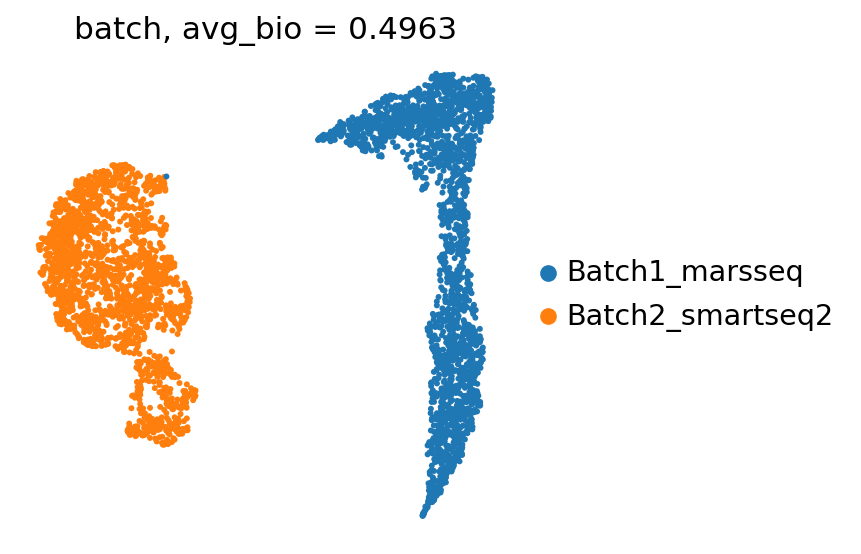

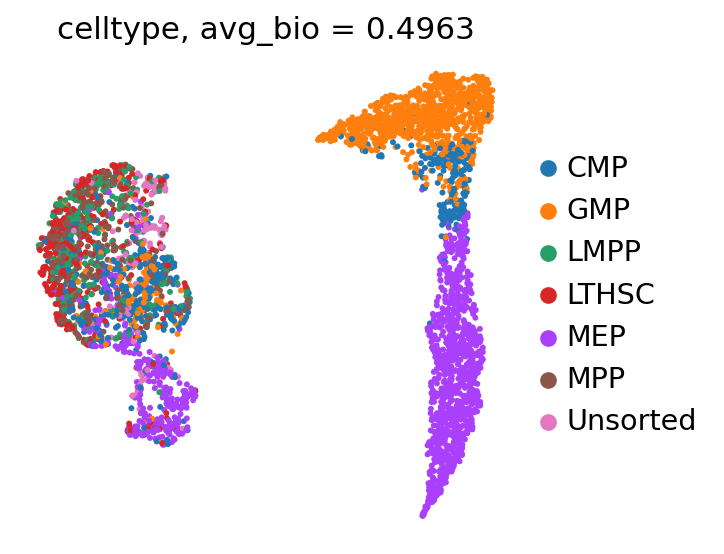

In [12]:
logger.info(f"Saving model to {save_dir}")
torch.save(best_model.state_dict(), save_dir / f"model_e{best_model_epoch}.pt")

# eval on testdata
results = eval_testdata(
    best_model,
    adata_t=adata_sorted if per_seq_batch_sample else adata,
    include_types=["cls"],
)
results["batch_umap"].savefig(
    save_dir / f"embeddings_batch_umap[cls]_e{best_model_epoch}.png", dpi=300
)

results["celltype_umap"].savefig(
    save_dir / f"embeddings_celltype_umap[cls]_e{best_model_epoch}.png", dpi=300
)
metrics_to_log = {"test/" + k: v for k, v in results.items()}
metrics_to_log["test/batch_umap"] = wandb.Image(
    str(save_dir / f"embeddings_batch_umap[cls]_e{best_model_epoch}.png"),
    caption=f"celltype avg_bio epoch {best_model_epoch}",
)

metrics_to_log["test/celltype_umap"] = wandb.Image(
    str(save_dir / f"embeddings_celltype_umap[cls]_e{best_model_epoch}.png"),
    caption=f"celltype avg_bio epoch {best_model_epoch}",
)
# metrics_to_log["test/best_model_epoch"] = best_model_epoch
wandb.log(metrics_to_log)
wandb.log({"avg_bio": results.get("avg_bio", 0.0)})

In [23]:
# test zero-shot
best_model = model

scGPT - INFO - Evaluating cls cell embeddings


100%|██████████| 139/139 [00:46<00:00,  2.97it/s]


NMI...
ARI...
Silhouette score...
PC regression...


/gpfs/gibbs/project/zhao/tl688/conda_envs/scgpt/lib/python3.8/site-packages/anndata/_core/anndata.py:447: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(
/gpfs/gibbs/project/zhao/tl688/conda_envs/scgpt/lib/python3.8/site-packages/anndata/_core/anndata.py:447: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(


Graph connectivity...
scGPT - INFO -                                   0
NMI_cluster/label          0.194757
ARI_cluster/label          0.047355
ASW_label                  0.522400
ASW_label/batch            0.894776
PCR_batch                  0.874518
cell_cycle_conservation         NaN
isolated_label_F1               NaN
isolated_label_silhouette       NaN
graph_conn                 0.998313
kBET                            NaN
iLISI                           NaN
cLISI                           NaN
hvg_overlap                     NaN
trajectory                      NaN
scGPT - INFO - Biological Conservation Metrics: 
ASW (cell-type): 0.5224, graph cLISI: nan, isolated label silhouette: nan, 
Batch Effect Removal Metrics: 
PCR_batch: 0.8745, ASW (batch): 0.8948, graph connectivity: 0.9983, graph iLISI: nan


/gpfs/gibbs/project/zhao/tl688/conda_envs/scgpt/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/gpfs/gibbs/project/zhao/tl688/conda_envs/scgpt/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/gpfs/gibbs/project/zhao/tl688/conda_envs/scgpt/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/gpfs/gibbs/project/zhao/tl688/conda_en

NameError: name 'best_model_epoch' is not defined

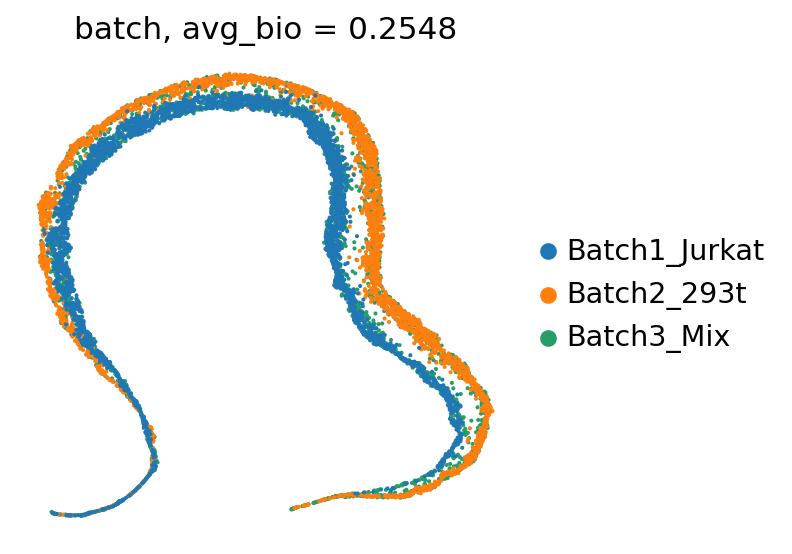

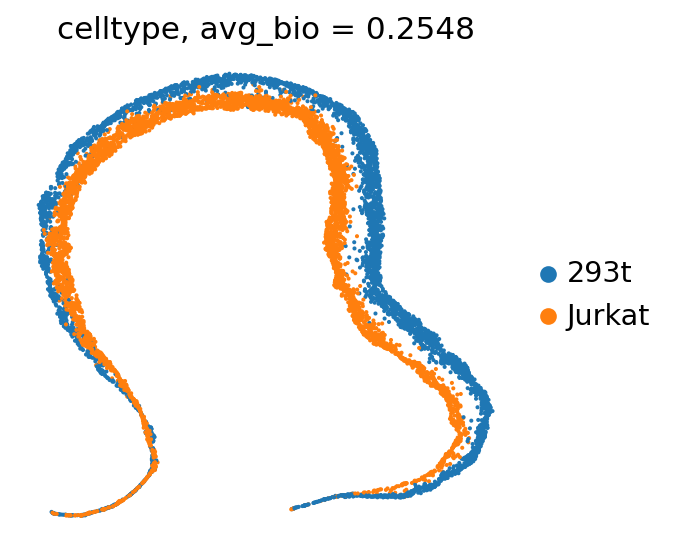

In [24]:
# eval on testdata
results = eval_testdata(
    best_model,
    adata_t=adata_sorted if per_seq_batch_sample else adata,
    include_types=["cls"],
)
results["batch_umap"].savefig(
    save_dir / f"embeddings_batch_umap[cls]_e{best_model_epoch}.png", dpi=300
)

results["celltype_umap"].savefig(
    save_dir / f"embeddings_celltype_umap[cls]_e{best_model_epoch}.png", dpi=300
)
metrics_to_log = {"test/" + k: v for k, v in results.items()}
metrics_to_log["test/batch_umap"] = wandb.Image(
    str(save_dir / f"embeddings_batch_umap[cls]_e{best_model_epoch}.png"),
    caption=f"celltype avg_bio epoch {best_model_epoch}",
)

metrics_to_log["test/celltype_umap"] = wandb.Image(
    str(save_dir / f"embeddings_celltype_umap[cls]_e{best_model_epoch}.png"),
    caption=f"celltype avg_bio epoch {best_model_epoch}",
)
metrics_to_log["test/best_model_epoch"] = best_model_epoch
wandb.log(metrics_to_log)
wandb.log({"avg_bio": results.get("avg_bio", 0.0)})